In [145]:
# Plotting library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec

# Numerical Library
import numpy as np
from numpy import genfromtxt
import collections, math, operator

from scipy.special import expit

# Limit printout to 3 decimal places
np.set_printoptions(precision=3,suppress=True)

# Allows for printing inline for jupyter notebook
%matplotlib inline 

In [146]:
## Part 1
DistanceFlagPair = collections.namedtuple('Distance', 'distance flag')

class DataFormat():

    def __init__(self, name):
        self.name = name

    def __init__(self, name = None, norm_data = None, flag_data = None):
        self.name = name
        if norm_data and flag_data:
            self.norm_data = np.array(norm_data)
            self.flag_data = np.array(flag_data)
        else:
            self.norm_data = norm_data
            self.flag_data = flag_data
        
    def func_data_set(self):
        src_data = genfromtxt(self.name, delimiter=',')
        flag_data = src_data[:,0]
        feature_data = np.delete(src_data, 0, axis=1)
        return feature_data, flag_data
        
    def func_norm_data(self):
        src_data = genfromtxt(self.name, delimiter=',')
        flag_data, feature_data = src_data[:,0], np.delete(src_data, 0, axis=1)
        feature_max, feature_min = np.amax(feature_data, axis=0), np.amin(feature_data, axis=0)
        feature_range, feature_avg = feature_max - feature_min, np.average(feature_data)
        norm_data = (feature_data - feature_avg) / feature_range
        self.norm_data, self.flag_data = norm_data, flag_data
        return norm_data, flag_data

    def func_leave_out(self, index):
        return self.norm_data[index], self.flag_data[index]

class KNN():

    def __init__(self, norm_data, flag_data):
        self.norm_data, self.flag_data = norm_data, flag_data

    def func_classify(self, test_data, k):
        neigbor_pair = self.func_build_neigbor(test_data)
        flag_sum = np.sum([neigbor.flag for neigbor in neigbor_pair[:k]])
        return -1 if flag_sum < 0 else 1
        
    def func_build_neigbor(self, test_data):
        diff_sqrt = (test_data - self.norm_data) ** 2
        distance_data = np.sqrt(np.sum(diff_sqrt, axis=1))
        neigbor_pair = []
        for i in range(len(distance_data)):
            neigbor = DistanceFlagPair(distance_data[i], self.flag_data[i])
            neigbor_pair.append(neigbor)
        return sorted(neigbor_pair, key=operator.attrgetter('distance'))        

def func_calc_error(data, knn, k = 1):
    temp_data = [knn.func_classify(classifier, k) for classifier in data.norm_data]
    return np.sum(np.abs(temp_data - data.flag_data)) / float(2 * len(data.flag_data))
    
def func_cross_valid_error(data, knn, k = 1):
    error = 0
    for i in range(len(data.norm_data)):
        norm, flag = data.func_leave_out(i)
        flag_sum = knn.func_classify(norm, k)
        flag_error = np.abs(flag - flag_sum) / 2
        error += flag_error
    return float(error) / (len(data.flag_data) + 1) 

In [147]:
## Part 2
class DecisionStump():

    def __init__(self, norm_data, flag_data):
        self.norm_data, self.flag_data = norm_data, flag_data

    def build_stump(self):
        row, col = self.norm_data.shape
        cur_info_gain, feature_num, split_num = 0, 0, 0
        for index in range(col):
            for value in self.norm_data.T[index]:
                tmp_info_gain = self.info_gain(index, value)
                if cur_info_gain < tmp_info_gain:
                    cur_info_gain = tmp_info_gain
                    feature_num, split_num = index, value
        return cur_info_gain, feature_num, split_num

    def info_gain(self, index, value):
        pos, neg = func_count_one(self.flag_data)
        init_entropy = func_calc_entropy(pos, neg)
        row_count, col_count = self.norm_data.shape
        upper_pos_count, upper_neg_count, lower_pos_count, lower_neg_count = self.count_one(index, value)
        upper_entropy = func_calc_entropy(upper_pos_count, upper_neg_count)
        upper_entropy = float(upper_pos_count + upper_neg_count) / row_count * upper_entropy
        lower_entropy = func_calc_entropy(lower_pos_count, lower_neg_count)
        lower_entropy = float(lower_pos_count + upper_neg_count) / row_count * lower_entropy
        return init_entropy - upper_entropy - lower_entropy

    def count_one(self, index, value):
        upper_pos_count, upper_neg_count = 0, 0
        lower_pos_count, lower_neg_count = 0, 0
        norm_data_t = self.norm_data.T[index]
        for i in range(len(norm_data_t)):
            tmp_value = norm_data_t[i]
            if tmp_value > value:
                if self.flag_data[i] > 0: upper_pos_count += 1
                else: upper_neg_count += 1
            else:
                if self.flag_data[i] > 0: lower_pos_count += 1
                else: lower_neg_count += 1
        return upper_pos_count, upper_neg_count, lower_pos_count, lower_neg_count

    def calc_error_rate(self, feature_num, split_num):
        predict, true, false = 0, 0, 0
        for i in range(len(self.norm_data)):
            predict = -1 if self.norm_data[i][feature_num] < split_num else 1
            if predict == self.flag_data[i]: true += 1
            else: false += 1
        return float(true) / (true + false)

class DecisionTree():

    def __init__(self, norm_data, flag_data, depth, height):
        self.norm_data, self.flag_data = norm_data, flag_data
        self.depth, self.height = depth, height
        self.predict = np.sum(flag_data)
        self.cur_info_gain, self.feature_num, self.split_num = 0, 0, 0
        if depth > 0:
            self.cur_info_gain, self.feature_num, self.split_num = self.build_stump()
            if self.cur_info_gain > 0:
                data_left, data_right = self.split_data(self.norm_data, self.flag_data, self.feature_num, self.split_num)
                left_norm_data, left_flag_data = data_left.norm_data, data_left.flag_data
                self.left_child = DecisionTree(left_norm_data, left_flag_data, self.depth - 1, self.height + 1)
                right_norm_data, right_flag_data = data_right.norm_data, data_right.flag_data
                self.right_child = DecisionTree(right_norm_data, right_flag_data, self.depth - 1, self.height + 1)
            else:
                self.depth = 0

    def build_stump(self):
        row, col = self.norm_data.shape
        cur_info_gain, feature_num, split_num = 0, 0, 0
        for index in range(col):
            for value in self.norm_data.T[index]:
                tmp_info_gain = self.info_gain(index, value)
                if cur_info_gain < tmp_info_gain:
                    cur_info_gain = tmp_info_gain
                    feature_num, split_num = index, value
        return cur_info_gain, feature_num, split_num

    def split_data(self, norm_data, flag_data, feature_num, split_num):
        left_norm, left_flag = [], []
        right_norm, right_flag = [], []
        for i in range(len(norm_data)):
            item_data = norm_data[i]
            if item_data[feature_num] > split_num:
                right_norm.append(item_data)
                right_flag.append(flag_data[i])
            else:
                left_norm.append(item_data)
                left_flag.append(flag_data[i])
        return DataFormat(norm_data = left_norm, flag_data = left_flag), DataFormat(norm_data = right_norm, flag_data = right_flag)

    def info_gain(self, index, value):
        pos, neg = func_count_one(self.flag_data)
        init_entropy = func_calc_entropy(pos, neg)
        row_count, col_count = self.norm_data.shape
        upper_pos_count, upper_neg_count, lower_pos_count, lower_neg_count = self.count_one(index, value)
        upper_entropy = func_calc_entropy(upper_pos_count, upper_neg_count)
        upper_entropy = float(upper_pos_count + upper_neg_count) * upper_entropy / row_count
        lower_entropy = func_calc_entropy(lower_pos_count, lower_neg_count)
        lower_entropy = float(lower_pos_count + lower_neg_count) * lower_entropy / row_count
        return init_entropy - upper_entropy - lower_entropy

    def count_one(self, index, value):
        upper_pos_count, upper_neg_count = 0, 0
        lower_pos_count, lower_neg_count = 0, 0
        norm_data_t = self.norm_data.T[index]
        for i in range(len(norm_data_t)):
            tmp_value = norm_data_t[i]
            if tmp_value > value:
                if self.flag_data[i] > 0: upper_pos_count += 1
                else: upper_neg_count += 1
            else:
                if self.flag_data[i] > 0: lower_pos_count += 1
                else: lower_neg_count += 1
        return upper_pos_count, upper_neg_count, lower_pos_count, lower_neg_count

    def calc_error_rate(self, norm_data):
        predict, true, false = 0, 0, 0
        for i in range(len(norm_data)):
            predict = self.calc_predict(norm_data[i])
            if predict > 0: true += 1
            else: false += 1
        return float(true) / (true + false)

    def calc_predict(self, norm_data):
        if self.depth > 0:
            return self.right_child.calc_predict(norm_data) if norm_data[self.feature_num] > self.split_num else self.left_child.calc_predict(norm_data)
        else:
            return 1 if self.predict > 0 else -1
    
    def print_tree(self):
        if self.depth > 0:
            print '|+++' * self.height + 'Feature:', self.feature_num, 'Split', self.split_num
            self.left_child.print_tree()
            print '|+++' * self.height + 'Feature:', self.feature_num, 'Split', self.split_num
            self.right_child.print_tree()
            print '|***' * self.height + 'Information Gain', self.cur_info_gain
        else:
            if self.predict > 0: print '|---' * self.height + 'Positive'
            elif self.predict < 0: print '|---' * self.height + 'Negative'
            else: print '|---' * self.height + 'Unpredictable'

def func_count_one(flag_data):
    pos, neg = 0, 0
    for data in flag_data:
        if data == 1: pos += 1
        if data == -1: neg += 1
    return pos, neg

def func_calc_entropy(pos, neg):
    try:
        lhs_prob, rhs_prob = float(pos) / (pos + neg), float(neg) / (pos + neg)
        entropy = lhs_prob * np.log(lhs_prob) + rhs_prob * np.log(rhs_prob)
        return -entropy
    except ZeroDivisionError:
        return 0

######################### Part I #########################
Training: [0.0, 0.017605633802816902, 0.017605633802816902, 0.021126760563380281, 0.031690140845070422, 0.042253521126760563, 0.031690140845070422, 0.035211267605633804, 0.035211267605633804, 0.03873239436619718, 0.042253521126760563, 0.042253521126760563, 0.045774647887323945, 0.052816901408450703, 0.052816901408450703, 0.052816901408450703, 0.049295774647887321, 0.052816901408450703, 0.049295774647887321, 0.052816901408450703, 0.059859154929577461, 0.059859154929577461, 0.066901408450704219, 0.066901408450704219, 0.066901408450704219, 0.066901408450704219]
Testing: [0.0, 0.021126760563380281, 0.042253521126760563, 0.035211267605633804, 0.042253521126760563, 0.042253521126760563, 0.045774647887323945, 0.045774647887323945, 0.045774647887323945, 0.045774647887323945, 0.045774647887323945, 0.045774647887323945, 0.049295774647887321, 0.049295774647887321, 0.049295774647887321, 0.049295774647887321, 0.052816901408450703, 0.0528169

D:\Development\Anaconda2\lib\site-packages\ipykernel\__main__.py:155: RuntimeWarning: divide by zero encountered in log
D:\Development\Anaconda2\lib\site-packages\ipykernel\__main__.py:155: RuntimeWarning: invalid value encountered in double_scalars


++++++++++++++++++++ Training Data ++++++++++++++++++++
Training Information Gain Value: 0.613224971014
Training Feature Value: 22
Training Error Rate: 0.933098591549
******************** Testing Data ********************
Testing Information Gain Value: 0.606475151087
Testing Feature Value: 27
Testing Error Rate: 0.890845070423
------------------------- Learning Decision Tree -------------------------
******************** Training Data ********************
Feature: 22 Split 0.333342293548
|+++Feature: 27 Split -213.024901513
|---|---Negative
|+++Feature: 27 Split -213.024901513
|+++|+++Feature: 1 Split -1.95389971867
|+++|+++|+++Feature: 27 Split -212.855766136
|---|---|---|---Negative
|+++|+++|+++Feature: 27 Split -212.855766136
|---|---|---|---Positive
|***|***|***Information Gain 0.196348159801
|+++|+++Feature: 1 Split -1.95389971867
|+++|+++|+++Feature: 20 Split -2.00424759455
|---|---|---|---Negative
|+++|+++|+++Feature: 20 Split -2.00424759455
|---|---|---|---Positive
|***|***|**

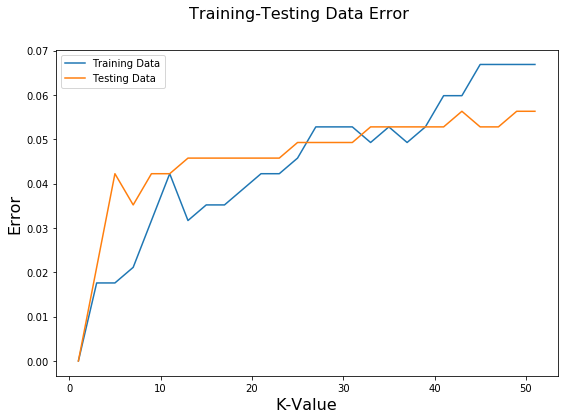

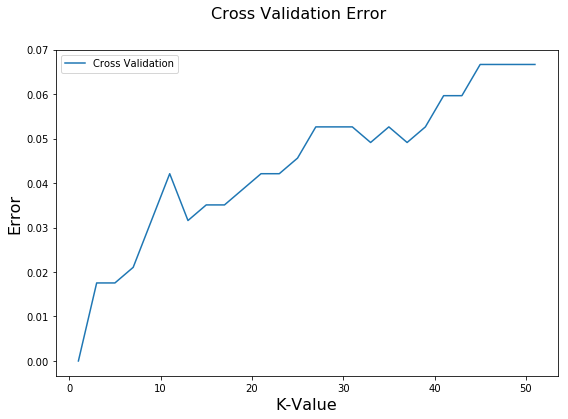

In [148]:
def func_plot_data(fig, x_list, y_list, label, title='Training-Testing Data'):
    plt.plot(x_list, y_list, label=label)
    plt.legend()
    fig.suptitle(title + ' Error', fontsize=16)
    plt.xlabel('K-Value', fontsize=16)
    plt.ylabel('Error', fontsize=16)

def func_part_one():
    train_data, test_data = DataFormat('knn_train.csv'), DataFormat('knn_test.csv')
    train_norm_data, train_flag_data = train_data.func_norm_data()
    test_norm_data, test_flag_data = test_data.func_norm_data()
    knn_train, knn_test = KNN(train_norm_data, train_flag_data), KNN(test_norm_data, test_flag_data)
    k_list, train_error_list, cross_valid_list, test_error_list = range(1, 52, 2), [], [], []
    
    for k in k_list:
        train_error = func_calc_error(train_data, knn_train, k)
        train_error_list.append(train_error)
        cross_valid = func_cross_valid_error(train_data, knn_train, k)
        cross_valid_list.append(cross_valid)
        test_error = func_calc_error(test_data, knn_test, k)
        test_error_list.append(test_error)

    fig = plt.figure(figsize=(9,6))
    print 'Training:', train_error_list
    func_plot_data(fig, k_list, train_error_list, 'Training Data')
    print 'Testing:', test_error_list    
    func_plot_data(fig, k_list, test_error_list, 'Testing Data')
    fig = plt.figure(figsize=(9,6))
    print 'Cross Valid:', cross_valid_list
    func_plot_data(fig, k_list, cross_valid_list, 'Cross Validation', 'Cross Validation')

def func_part_two():
    train_data, test_data = DataFormat('knn_train.csv'), DataFormat('knn_test.csv')
    train_norm_data, train_flag_data = train_data.func_norm_data()
    test_norm_data, test_flag_data = test_data.func_norm_data()
    print '-' * 25, 'Learning Decision Stump', '-' * 25
    train_stump, test_stump = DecisionStump(train_norm_data, train_flag_data), DecisionStump(test_norm_data, test_flag_data)
    train_info_gain, train_feature, train_split = train_stump.build_stump()
    test_info_gain, test_feature, test_split = test_stump.build_stump()
    print '+' * 20, 'Training Data', '+' * 20
    print 'Training Information Gain Value:', train_info_gain
    print 'Training Feature Value:', train_feature
#     print 'Training Splitted Value:', train_split
    print 'Training Error Rate:', train_stump.calc_error_rate(train_feature, train_split)
    print '*' * 20, 'Testing Data', '*' * 20
    print 'Testing Information Gain Value:', test_info_gain
    print 'Testing Feature Value:', test_feature
#     print 'Testing Splitted Value:', test_split
    print 'Testing Error Rate:', test_stump.calc_error_rate(test_feature, test_split)
    print '-' * 25, 'Learning Decision Tree', '-' * 25
    train_tree = DecisionTree(train_norm_data, train_flag_data, 5, 0)
    test_tree = DecisionTree(test_norm_data, test_flag_data, 5, 0)
    print '*' * 20, 'Training Data', '*' * 20
    train_tree.print_tree()
    print 'Training Error Rate:', train_tree.calc_error_rate(train_norm_data)
    print '*' * 20, 'Testing Data', '*' * 20
    test_tree.print_tree()    
    print 'Testing Error Rate:', test_tree.calc_error_rate(test_norm_data)

if __name__ == '__main__':
    print '#' * 25, 'Part I', '#' * 25
    func_part_one()
    print '#' * 25, 'Part II', '#' * 25
    func_part_two()